# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from post_analysis_clustering.utils import timer

In [3]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target
df_iris['species_name'] = df_iris['species'].map(dict(zip(range(3), iris.target_names)))
df_iris = df_iris.reset_index(names='id')
df_iris = df_iris.drop(columns='species')

df_iris.head()

,id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_name
0,0,5.1,3.5,1.4,0.2,setosa
1,1,4.9,3.0,1.4,0.2,setosa
2,2,4.7,3.2,1.3,0.2,setosa
3,3,4.6,3.1,1.5,0.2,setosa
4,4,5.0,3.6,1.4,0.2,setosa


# prep data

In [4]:
from post_analysis_clustering.prep_data import get_feature_list, get_numeric_feature_lists

In [5]:
iris_feature_list = get_feature_list(df=df_iris)
iris_feature_list

Execution time for get_feature_list: 0.0001 seconds


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [6]:
# iris_feature_list = df_iris.drop(columns=['id','species_name'],axis=1).columns.to_list()
# iris_feature_list

In [7]:
cont_feature_list, disc_feature_list = get_numeric_feature_lists(df=df_iris, 
                                       primary_key='id', 
                                       target_cluster='species_name',
                                       nunique_threshold = 20)

Ignoring column 'id' — marked as primary key or target cluster.
Ignoring column 'species_name' — marked as primary key or target cluster.

Analyzing numerical features:
  • 'sepal length (cm)' has 35 unique values
    → Classified as CONTINUOUS (35 ≥ 20)
  • 'sepal width (cm)' has 23 unique values
    → Classified as CONTINUOUS (23 ≥ 20)
  • 'petal length (cm)' has 43 unique values
    → Classified as CONTINUOUS (43 ≥ 20)
  • 'petal width (cm)' has 22 unique values
    → Classified as CONTINUOUS (22 ≥ 20)
Execution time for get_numeric_feature_lists: 0.0019 seconds


In [8]:
cont_feature_list

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [9]:
disc_feature_list

[]

# lean feature

## Importance Rank

In [10]:
import post_analysis_clustering.lean_feature as lf

In [11]:
lean  = lf.LeanFeature(df = df_iris,
                 features = iris_feature_list,
                 target_cluster = 'species_name',
                 n_rank=5,
                vote_score=3)

In [12]:
final_imp, final_pvt_imp_score,final_cumsum = lean._cal_imp_all_binary_class()

Processing segment setosa
Execution time for _prep_binary_class: 0.0020 seconds

Training Decision Tree...
Execution time for _calculate_permutation_importance: 0.0822 seconds
Execution time for _train_and_evaluate_model: 0.0985 seconds

Training Random Forest...
Execution time for _calculate_permutation_importance: 0.3391 seconds
Execution time for _train_and_evaluate_model: 0.4988 seconds

Training HistGradientBoosting...
Execution time for _calculate_permutation_importance: 0.1371 seconds
Execution time for _train_and_evaluate_model: 0.2090 seconds

Training Logistic Regression...
Execution time for _calculate_permutation_importance: 0.1086 seconds
Execution time for _train_and_evaluate_model: 0.1275 seconds

Training Logistic Regression (L1)...
Execution time for _calculate_permutation_importance: 0.0800 seconds
Execution time for _train_and_evaluate_model: 0.0929 seconds

Training Naive Bayes...
Execution time for _calculate_permutation_importance: 0.0811 seconds
Execution time fo

In [13]:
final_pvt_imp_score

,Feature,1,2,3,4,Segment
0,petal length (cm),5,1,0,0,setosa
1,petal width (cm),2,4,0,0,setosa
2,sepal length (cm),0,5,1,0,setosa
3,sepal width (cm),0,4,2,0,setosa
4,petal length (cm),2,3,0,1,versicolor
5,petal width (cm),4,2,0,0,versicolor
6,sepal length (cm),0,0,4,2,versicolor
7,sepal width (cm),0,1,4,1,versicolor
8,petal length (cm),3,3,0,0,virginica
9,petal width (cm),3,3,0,0,virginica


In [14]:
final_imp

,Feature,Decision Tree,Random Forest,HistGradientBoosting,Logistic Regression,Logistic Regression (L1),Naive Bayes,Segment
0,petal length (cm),0.520000,0.073333,0.520000,0.515556,0.517778,0.260000,setosa
1,petal width (cm),0.000000,0.106667,0.000000,0.000000,0.000000,0.260000,setosa
2,sepal length (cm),0.000000,0.000000,0.000000,0.000000,0.000000,0.024444,setosa
3,sepal width (cm),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,setosa
4,petal length (cm),0.340000,0.124444,0.388889,0.077778,-0.020000,0.148889,versicolor
5,petal width (cm),0.106667,0.128889,0.128889,0.086667,0.080000,0.177778,versicolor
6,sepal length (cm),0.000000,0.000000,0.024444,0.006667,-0.013333,0.022222,versicolor
7,sepal width (cm),0.000000,0.000000,0.008889,0.031111,0.013333,0.044444,versicolor
8,petal length (cm),0.197778,0.131111,0.288889,0.273333,0.240000,0.128889,virginica
9,petal width (cm),0.242222,0.171111,0.104444,0.175556,0.184444,0.146667,virginica


In [15]:
lean._bin_cumsum_percentiles()

(bin            Feature  single_imp  pct_10  pct_20  pct_30  pct_40  pct_50  \
 0     sepal width (cm)           6       0       0       0       0       0   
 1    sepal length (cm)           6       0       0       0       0       0   
 2     petal width (cm)           0       0       0       0       0       0   
 3    petal length (cm)           0       0       0       0       0       1   
 4     sepal width (cm)           0       0       0       0       0       0   
 5    sepal length (cm)           0       0       0       0       0       0   
 6     petal width (cm)           0       0       0       0       0       2   
 7    petal length (cm)           0       0       0       0       0       0   
 8     sepal width (cm)           0       0       0       0       0       0   
 9    sepal length (cm)           0       0       0       0       0       0   
 10    petal width (cm)           0       0       0       0       0       0   
 11   petal length (cm)           0       0       0 

In [16]:
final_cumsum

,Feature,variable,value,rank,cumsum,cumsum_pct,Segment
0,petal length (cm),Decision Tree,0.520000,1,0.520000,1.000000,setosa
1,petal width (cm),Decision Tree,0.000000,2,0.520000,1.000000,setosa
2,sepal length (cm),Decision Tree,0.000000,2,0.520000,1.000000,setosa
3,sepal width (cm),Decision Tree,0.000000,2,0.520000,1.000000,setosa
4,petal length (cm),HistGradientBoosting,0.520000,1,0.520000,1.000000,setosa
...,...,...,...,...,...,...,...
67,sepal length (cm),Naive Bayes,-0.015556,4,0.275556,1.000000,virginica
68,petal width (cm),Random Forest,0.171111,1,0.171111,0.566176,virginica
69,petal length (cm),Random Forest,0.131111,2,0.302222,1.000000,virginica
70,sepal length (cm),Random Forest,0.000000,3,0.302222,1.000000,virginica


Plotting heatmap for segment setosa


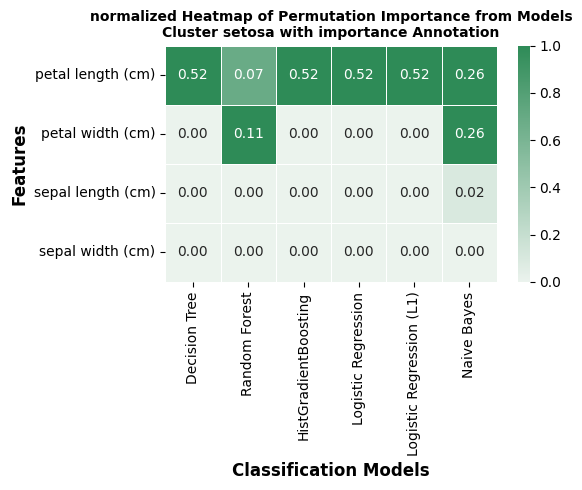

Plotting heatmap for segment versicolor


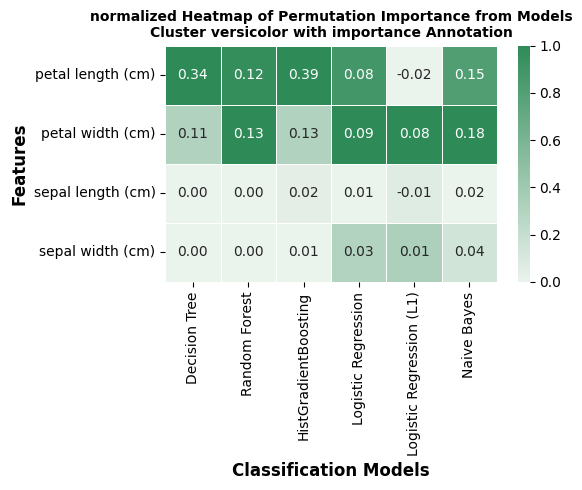

Plotting heatmap for segment virginica


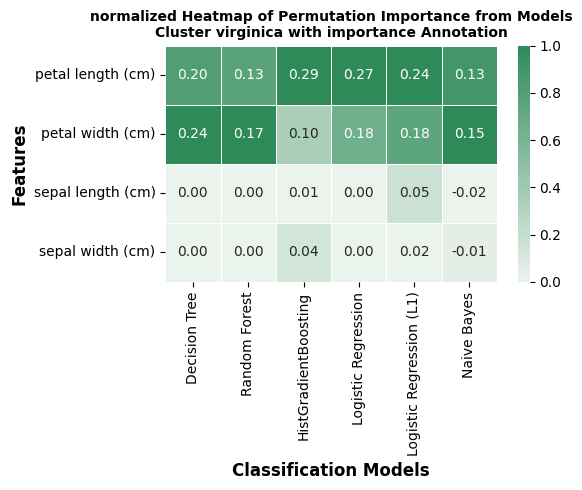

Execution time for _plot_heatmap_imp_all_binary_class: 0.7601 seconds


In [17]:
lean._plot_heatmap_imp_all_binary_class(compare_type = 'Normalized',
                                           annot_type = 'Importance')

Plotting heatmap for segment setosa


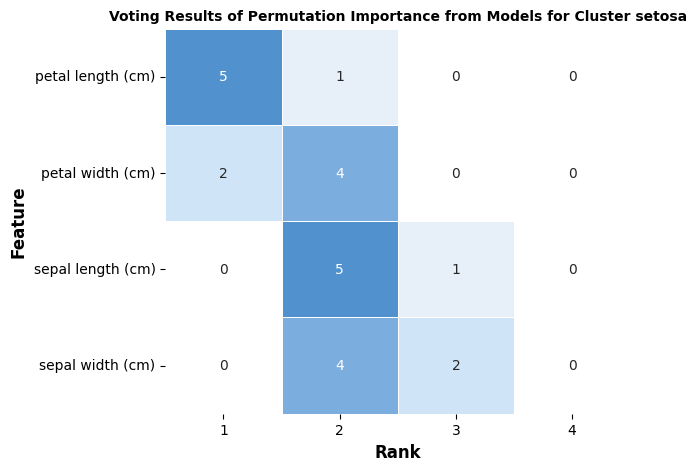

Plotting heatmap for segment versicolor


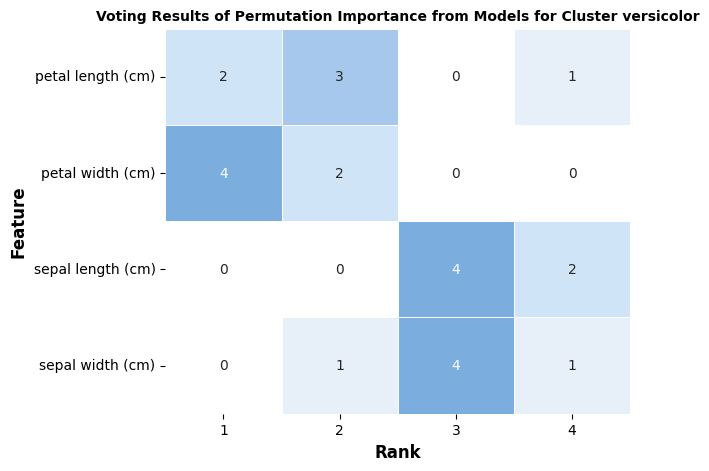

Plotting heatmap for segment virginica


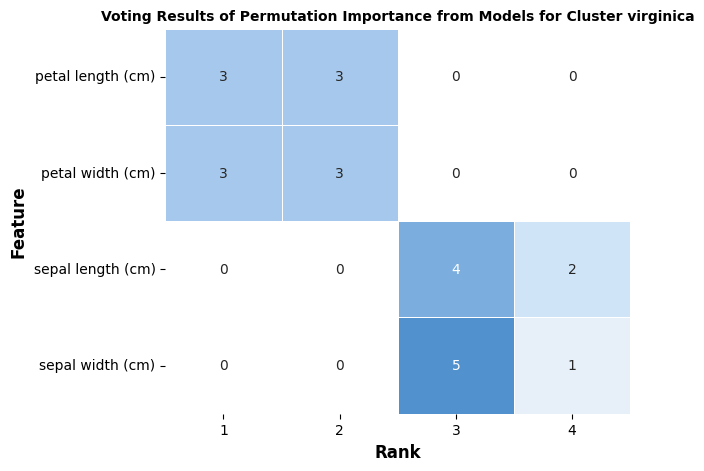

Execution time for _plot_vote_result_all_binary_class: 0.4684 seconds


In [18]:
lean._plot_vote_result_all_binary_class()

In [19]:
cluster_lean_features_dict, union_lean_feature_list = lean.ImportanceRank_imp_features()

Threshold of vote score >= 3
Cluster setosa:
  Total features from raw: 4
  Total features remaining after threshold filter: 4
Cluster versicolor:
  Total features from raw: 4
  Total features remaining after threshold filter: 4
Cluster virginica:
  Total features from raw: 4
  Total features remaining after threshold filter: 4

Union across all clusters:
  Total union features: 4
Execution time for ImportanceRank_imp_features: 0.0080 seconds


In [20]:
cluster_lean_features_dict['setosa']

['petal length (cm)',
 'petal width (cm)',
 'sepal length (cm)',
 'sepal width (cm)']

In [21]:
union_lean_feature_list

['petal length (cm)',
 'petal width (cm)',
 'sepal length (cm)',
 'sepal width (cm)']

In [22]:
cluster_lean_features_dict

{np.str_('setosa'): ['petal length (cm)',
  'petal width (cm)',
  'sepal length (cm)',
  'sepal width (cm)'],
 np.str_('versicolor'): ['petal length (cm)',
  'petal width (cm)',
  'sepal length (cm)',
  'sepal width (cm)'],
 np.str_('virginica'): ['petal length (cm)',
  'petal width (cm)',
  'sepal length (cm)',
  'sepal width (cm)']}

## Importance Threshold

In [23]:
import post_analysis_clustering.lean_feature as lf

In [24]:
lean  = lf.LeanFeature(df = df_iris,
                 features = iris_feature_list,
                 target_cluster = 'species_name',
                 n_rank=5,
                vote_score=3)

In [25]:
lean._prep_rank_importance(focus_segment='setosa')

Execution time for _prep_binary_class: 0.0017 seconds

Training Decision Tree...
Execution time for _calculate_permutation_importance: 0.0846 seconds
Execution time for _train_and_evaluate_model: 0.0991 seconds

Training Random Forest...
Execution time for _calculate_permutation_importance: 0.3347 seconds
Execution time for _train_and_evaluate_model: 0.4930 seconds

Training HistGradientBoosting...
Execution time for _calculate_permutation_importance: 0.1496 seconds
Execution time for _train_and_evaluate_model: 0.2267 seconds

Training Logistic Regression...
Execution time for _calculate_permutation_importance: 0.0971 seconds
Execution time for _train_and_evaluate_model: 0.1173 seconds

Training Logistic Regression (L1)...
Execution time for _calculate_permutation_importance: 0.0743 seconds
Execution time for _train_and_evaluate_model: 0.0868 seconds

Training Naive Bayes...
Execution time for _calculate_permutation_importance: 0.0843 seconds
Execution time for _train_and_evaluate_mode

,Feature,variable,value,rank,cumsum,cumsum_pct
0,petal length (cm),Decision Tree,0.520000,1,0.520000,1.000000
1,petal width (cm),Decision Tree,0.000000,2,0.520000,1.000000
2,sepal length (cm),Decision Tree,0.000000,2,0.520000,1.000000
3,sepal width (cm),Decision Tree,0.000000,2,0.520000,1.000000
8,petal length (cm),HistGradientBoosting,0.520000,1,0.520000,1.000000
9,petal width (cm),HistGradientBoosting,0.000000,2,0.520000,1.000000
10,sepal length (cm),HistGradientBoosting,0.000000,2,0.520000,1.000000
11,sepal width (cm),HistGradientBoosting,0.000000,2,0.520000,1.000000
12,petal length (cm),Logistic Regression,0.515556,1,0.515556,1.000000
13,petal width (cm),Logistic Regression,0.000000,2,0.515556,1.000000


In [26]:
final_cumsum

,Feature,variable,value,rank,cumsum,cumsum_pct,Segment
0,petal length (cm),Decision Tree,0.520000,1,0.520000,1.000000,setosa
1,petal width (cm),Decision Tree,0.000000,2,0.520000,1.000000,setosa
2,sepal length (cm),Decision Tree,0.000000,2,0.520000,1.000000,setosa
3,sepal width (cm),Decision Tree,0.000000,2,0.520000,1.000000,setosa
4,petal length (cm),HistGradientBoosting,0.520000,1,0.520000,1.000000,setosa
...,...,...,...,...,...,...,...
67,sepal length (cm),Naive Bayes,-0.015556,4,0.275556,1.000000,virginica
68,petal width (cm),Random Forest,0.171111,1,0.171111,0.566176,virginica
69,petal length (cm),Random Forest,0.131111,2,0.302222,1.000000,virginica
70,sepal length (cm),Random Forest,0.000000,3,0.302222,1.000000,virginica


In [51]:
bin_cumsum_df, final_pvt_cumsum_score = lean._bin_cumsum_percentiles(bin_size=20)
final_pvt_cumsum_score

Using threshold of 80% to determine feature importance across models.


,Feature,single_imp,pct=<thres,Segment
0,sepal width (cm),6,0,setosa
1,sepal length (cm),6,0,setosa
2,petal width (cm),0,1,setosa
3,petal length (cm),0,1,setosa
4,sepal width (cm),0,0,versicolor
5,sepal length (cm),0,0,versicolor
6,petal width (cm),0,3,versicolor
7,petal length (cm),0,2,versicolor
8,sepal width (cm),0,0,virginica
9,sepal length (cm),0,0,virginica


In [46]:
bin_cumsum_df

bin,Feature,single_imp,pct_20,pct_40,pct_60,pct_80,pct_99.99,pct_100,Segment
0,sepal width (cm),6,0,0,0,0,0,6,setosa
1,sepal length (cm),6,0,0,0,0,0,6,setosa
2,petal width (cm),0,0,0,1,0,1,4,setosa
3,petal length (cm),0,0,0,1,0,0,5,setosa
4,sepal width (cm),0,0,0,0,0,2,4,versicolor
5,sepal length (cm),0,0,0,0,0,1,5,versicolor
6,petal width (cm),0,0,0,3,0,2,1,versicolor
7,petal length (cm),0,0,0,0,2,2,2,versicolor
8,sepal width (cm),0,0,0,0,0,1,5,virginica
9,sepal length (cm),0,0,0,0,0,1,5,virginica


In [54]:
lean.ImportanceThreshold_imp_features()

Threshold of vote score >= 3
Cluster setosa:
  Total features from raw: 4
  Total features remaining after threshold filter: 2
Cluster versicolor:
  Total features from raw: 4
  Total features remaining after threshold filter: 1
Cluster virginica:
  Total features from raw: 4
  Total features remaining after threshold filter: 2

Union across all clusters:
  Total union features: 4
Execution time for ImportanceThreshold_imp_features: 0.0081 seconds


({np.str_('setosa'): ['sepal length (cm)', 'sepal width (cm)'],
  np.str_('versicolor'): ['petal width (cm)'],
  np.str_('virginica'): ['petal length (cm)', 'petal width (cm)']},
 ['petal length (cm)',
  'petal width (cm)',
  'sepal length (cm)',
  'sepal width (cm)'])

In [26]:
df_cumsum

,Feature,Decision Tree,cumsum,cumsum_pct,Segment,Model,Random Forest,HistGradientBoosting,Logistic Regression,Logistic Regression (L1),Naive Bayes
0,petal length (cm),0.52,0.520000,1.000000,setosa,Decision Tree,NaN,NaN,NaN,NaN,NaN
1,petal width (cm),0.00,0.520000,1.000000,setosa,Decision Tree,NaN,NaN,NaN,NaN,NaN
2,sepal length (cm),0.00,0.520000,1.000000,setosa,Decision Tree,NaN,NaN,NaN,NaN,NaN
3,sepal width (cm),0.00,0.520000,1.000000,setosa,Decision Tree,NaN,NaN,NaN,NaN,NaN
4,petal width (cm),NaN,0.106667,0.592593,setosa,Random Forest,0.106667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
67,sepal width (cm),NaN,0.493333,1.000000,virginica,Logistic Regression (L1),NaN,NaN,NaN,0.015556,NaN
68,petal width (cm),NaN,0.146667,0.584071,virginica,Naive Bayes,NaN,NaN,NaN,NaN,0.146667
69,petal length (cm),NaN,0.275556,1.097345,virginica,Naive Bayes,NaN,NaN,NaN,NaN,0.128889
70,sepal width (cm),NaN,0.266667,1.061947,virginica,Naive Bayes,NaN,NaN,NaN,NaN,-0.008889


In [27]:
df_cumsum_pct

,Feature,Segment,Model,cumsum_pct
0,petal length (cm),setosa,Decision Tree,1.000000
1,petal width (cm),setosa,Decision Tree,1.000000
2,sepal length (cm),setosa,Decision Tree,1.000000
3,sepal width (cm),setosa,Decision Tree,1.000000
4,petal width (cm),setosa,Random Forest,0.592593
...,...,...,...,...
67,sepal width (cm),virginica,Logistic Regression (L1),1.000000
68,petal width (cm),virginica,Naive Bayes,0.584071
69,petal length (cm),virginica,Naive Bayes,1.097345
70,sepal width (cm),virginica,Naive Bayes,1.061947


# visualization

In [24]:
import post_analysis_clustering.visualize as vs

In [25]:
vs.VisualizeCluster()

TypeError: VisualizeCluster.__init__() missing 1 required positional argument: 'save_dir'

In [27]:
vs.DimensionalityReduction()

TypeError: DimensionalityReduction.__init__() missing 1 required positional argument: 'save_dir'

In [28]:
vs.OverlapPairPlot()

TypeError: OverlapPairPlot.__init__() missing 1 required positional argument: 'save_dir'

In [29]:
vs.PerformanceMetrics()

TypeError: PerformanceMetrics.__init__() missing 1 required positional argument: 'save_dir'

In [30]:
vs.ProfileData()

TypeError: ProfileData.__init__() missing 1 required positional argument: 'save_dir'